This script illustrates how to test a 2D U-Net on a 3D EM volume. 

We will start by loading in the required modules and configuring the environment. 

In [1]:
# configure environment
import sys
sys.path.append('/home/jorisro/research/neuralnets')  # adjust this if necessary! This should point to the neuralnets repository

# dependencies
import numpy as np
import yaml
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from multiprocessing import freeze_support

from neuralnets.networks.unet import UNet2D
from neuralnets.util.io import print_frm, rmdir, cp, read_volume
from neuralnets.util.tools import set_seed, parse_params
from neuralnets.util.validation import segment

We need to initialize the model, so it's advised to use the same parameter configuration file as with the training notebook. 

In [2]:
param_config_file = 'train.yaml'  # adjust this path/file if necessary! 
with open(param_config_file) as file:
    params = parse_params(yaml.load(file, Loader=yaml.FullLoader))

We will now load the dataset that we want to test. 

In [3]:
# input shape as a 3-tuple (e.g. (1, 256, 256))
input_shape = (1, *(params['input_size']))  

# extract the volume that needs to be segmented
print_frm('Loading data')
test_data_path = '/home/jorisro/research/data/EM/EPFL/volumedata'
test_data = read_volume(test_data_path, type='pngseq', progress=True, start=0, stop=100)

[2022-05-24 13:08:07.665623] Loading data


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 49.28it/s]


As an illustration, we can show a randomly selected sample of this dataset. 

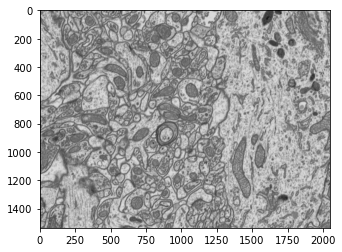

In [4]:
x = test_data[np.random.randint(len(test_data))]
plt.imshow(x, cmap='gray')
plt.show()

Now that we have data, it's time to intialize the model! 

In [5]:
print_frm('Building the network')
net = UNet2D(in_channels=params['in_channels'], feature_maps=params['fm'], levels=params['levels'],
             dropout_enc=params['dropout'], dropout_dec=params['dropout'], norm=params['norm'],
             activation=params['activation'], coi=params['coi'], loss_fn=params['loss'])

# load the parameters of the model
ckpt_file = 'model.ckpt'
net.load_state_dict(torch.load(ckpt_file)['state_dict'])

[2022-05-24 13:08:09.970203] Building the network


<All keys matched successfully>

We can now apply the model on a single slice...

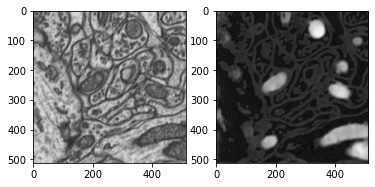

In [6]:
device = 'cuda:0'

# convert numpy array into a float tensor
slice_index = 0
x_np = test_data[slice_index][:512, :512]
x = torch.from_numpy(x_np).to(device).float()

# add batch and channel dimension
x = x.unsqueeze(0).unsqueeze(0)

# map network to the device
net.to(device)

# forward propation
y = net(x)

# convert to numpy array, not that we select channel 1 as it correspond to the class probability predictions that correspond to the mitochondria
y = y.detach().cpu().numpy()[0, 1]

# visualize
plt.subplot(1, 2, 1)
plt.imshow(x_np, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.show()

... or on a complete volume! 

In [7]:
net.load_state_dict(torch.load(ckpt_file)['state_dict'])
y = segment(test_data, net, params['input_size'], in_channels=params['in_channels'], track_progress=True)

Progress z-axis:   0%|          | 0/100 [00:00<?, ?it/s]

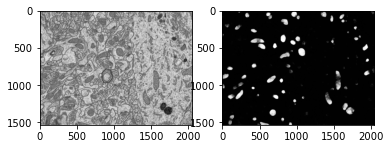

In [8]:
slice_index = 10
plt.subplot(1, 2, 1)
plt.imshow(test_data[slice_index], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y[1, slice_index], cmap='gray')
plt.show()

The segmentation result from the `segment` function is a C x Z x Y x X numpy array, i.e. the predictions of the model for each class. 